# Using Continuous-Time Bayesian Networks

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pyagrum.ctbn as ct
import pyagrum.ctbn.notebook as ctbnnb

A CTBN(Continuous-Time Bayesian Networks) is a graphical model that allows a Bayesian Network to evolve over continuous time.

(For more details see https://pyagrum.readthedocs.io/en/latest/ctbn.html)

## Creating a CTBN

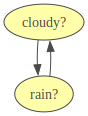

In [2]:
# 1. Creating the ctbn
ctbn = ct.CTBN()

# 2. Adding the random variables
ctbn.add(gum.LabelizedVariable("cloudy?", "cloudy?"))
ctbn.add(gum.LabelizedVariable("rain?", "rain?"))

# 3. Adding the arcs
ctbn.addArc("cloudy?", "rain?")
ctbn.addArc("rain?", "cloudy?")

# 4. Filling the CIMS (Conditional Intensity Matrixes)
ctbn.CIM("cloudy?")[{"rain?": "0"}] = [[-.1, .1],
                                        [1, -1]]
ctbn.CIM("cloudy?")[{"rain?": "1"}] = [[-100, 100],
                                        [.5, -.5]]

ctbn.CIM("rain?")[{"cloudy?": "0"}] = [[-0.5, 0.5],
                                        [1000, -1000]]
ctbn.CIM("rain?")[{"cloudy?": "1"}] = [[-2, 2],
                                        [2, -2]]

# 5. Plotting the CTBN (whith/whithout the CIMs)
ctbnnb.showCtbnGraph(ctbn)
ctbnnb.showCIMs(ctbn)


``cloudy?#i`` gives the state ``cloudy?`` is currently in and ``cloudy?#j`` gives its next state.

The ``CIM`` object, built around a ``pyagrum.Tensor`` is used to store the parameters of the variables, describing the waiting time before
switching to another state.

A useful tool for CIMs, mainly used for simple inference, is ``amalgamation``. It allows to merge many CIMs into one.

In [3]:
cimA = ctbn.CIM("cloudy?")
cimB = ctbn.CIM("rain?")
amal = cimA.amalgamate(cimB) # or cimA * cimB

amal.getTensor() # as a Tensor

(pyagrum.Tensor@0x600002c74ae0) 
                    ||  cloudy?#j        |
cloudy|rain?#|rain?#||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || -0.6000 | 0.1000  |
1     |0     |0     || 1.0000  | -3.0000 |
0     |1     |0     || 1000.0000| 0.0000  |
1     |1     |0     || 0.0000  | 2.0000  |
0     |0     |1     || 0.5000  | 0.0000  |
1     |0     |1     || 0.0000  | 2.0000  |
0     |1     |1     || -1100.0000| 100.0000|
1     |1     |1     || 0.5000  | -2.5000 |

In [4]:
print("\nJoint intensity matrix as numpy array\n")
print(amal.toMatrix()) # as a numpy array


Joint intensity matrix as numpy array

[[-6.0e-01  1.0e-01  5.0e-01  0.0e+00]
 [ 1.0e+00 -3.0e+00  0.0e+00  2.0e+00]
 [ 1.0e+03  0.0e+00 -1.1e+03  1.0e+02]
 [ 0.0e+00  2.0e+00  5.0e-01 -2.5e+00]]


A random variable of a ctbn can be identified by either its name or id.

In any case, most class functions parameters allow for a variable to be identified by either its name or id (``type NameOrId``).

In [5]:
labels_with_id = ctbn.labels(0)
labels_with_name = ctbn.labels("cloudy?")
print(f"labels using id : {labels_with_id}, using name : {labels_with_name}")

variable_with_id = ctbn.variable(0)
variable_with_name = ctbn.variable("cloudy?")
print(f"The variables 0 and 'cloudy?' are the same ? {variable_with_id==variable_with_name}")

labels using id : ('0', '1'), using name : ('0', '1')
The variables 0 and 'cloudy?' are the same ? True


All functions with NameOrId parameters work the same way

### Random CTBN generator
The ``CtbnGenerator`` module can be used to quickly generate CTBNs. The parameters value are drawn at random from a value range. The diagonal coefficients are just the negative sum of the ones on the same line (in a CIM). It is also possible to choose the number of variables, the maximum number of parents a variable can have, and the domain size of the variables.

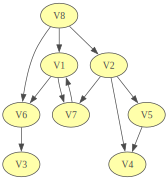

In [6]:
randomCtbn = ct.randomCTBN(valueRange=(1,10), n=8, parMax=2, modal=2)

ctbnnb.showCtbnGraph(randomCtbn)
ctbnnb.showCIMs(randomCtbn)

## Inference with CTBNs

### Exact inference & Forward Sampling inference

- Amalgamation is used to compute exact inference. It consists in merging all the CIMs of a CTBN into one CIM.
Then we use the properties of markov process : $P(X_t) = P(X_0)*exp(Q_Xt)$ for enough time to notice convergence.

- Forward sampling works this way:
    - At time $t$ :
    - Draw a "time until next change" $dt$ value for each variable's exponential distribution of their waiting time.
    - Select the variable with smallest transition time : $next time = t + dt$.
    - Draw the variable next state uniformly.
    - loop until $t = timeHorizon$.

When doing forward sampling, we first iterate this process over a given amount of iterations (called burnIn). We consider the last values as the initial configuration for sampling. The reason is that the initial state of a CTBN is unknown without real data.

In [7]:
# 1. Initialiaze Inference object
ie = ct.SimpleInference(ctbn)
ie_forward = ct.ForwardSamplingInference(ctbn)
gnb.sideBySide(ctbnnb.getCtbnGraph(ctbn), ctbnnb.getCtbnInference(ctbn, ie), ctbnnb.getCtbnInference(ctbn, ie_forward))

ctbn <!-- cloudy? --> cloudy? cloudy? <!-- rain? --> rain? rain? <!-- cloudy?->rain? --> cloudy?->rain? <!-- rain?->cloudy? --> rain?->cloudy?


In any case, inference can be made using ``makeInference()`` function from every Inference object.

In [8]:
import time
# Simple inference
time1 = time.time()
ie.makeInference(t=5000)
pot1 = ie.posterior("cloudy?")
elapsed1 = time.time() - time1

# Sampling inference
time2 = time.time()
ie_forward.makeInference(timeHorizon=5000, burnIn=100)
pot2 = ie_forward.posterior("cloudy?")
elapsed2 = time.time() - time2

gnb.sideBySide(gnb.getTensor(pot1), gnb.getTensor(pot2), captions=[f"Simple inference {round(elapsed1*1000,2)} ms", f"Sampling inference {round(elapsed2*1000, 2)} ms"])

## Plotting a sample
Here is an example of a trajectory plot

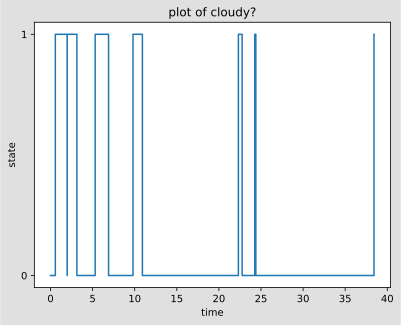

In [9]:
# 1_1. Find trajectory stored in the inference class
ie_forward.makeInference()
traj = ie_forward.trajectory # a single trajectory List[Tuple[float, str, str]]

# 1_2. Or find it in a csv file
ie_forward.writeTrajectoryCSV('out/trajectory.csv', n=1, timeHorizon=1000, burnIn=100) # to save a trajectory
traj = ct.readTrajectoryCSV('out/trajectory.csv') # a dict of trajectories

# 2. Plot the trajectory
ct.plotTrajectory(ctbn.variable("cloudy?"), traj[0], timeHorizon=40, plotname="plot of cloudy?")

It is also possible to plot the proportions of the states a variable is in over time.

Let's take the exemple of a variable with domain size=5.

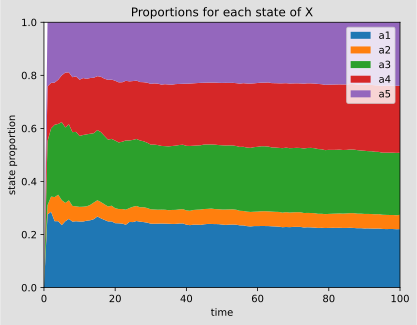

In [10]:
# 1. Create CTBN
new_ctbn = ct.CTBN()
X = gum.LabelizedVariable("X", "X", ["a1", "a2", "a3", "a4", "a5"])
new_ctbn.add(X)
new_ctbn.CIM("X")[:] = [[-10, 2, 4, 0, 4],
                        [0.5 , -1, 0.5, 0, 0],
                        [5, 0.5, -10, 3.5, 1],
                        [50, 0.5, 50, -200.5, 100],
                        [1, 0, 2, 7, -10]]
# 2. Sampling 
ieX = ct.ForwardSamplingInference(new_ctbn)
ieX.writeTrajectoryCSV("out/traj_quinary.csv", n=3, timeHorizon=100)
trajX = ct.readTrajectoryCSV("out/traj_quinary.csv") 

# 3. Plotting
ct.plotFollowVar(X, trajX)

## CTBN Learning with pyAgrum
The ctbn library has tools to learn the graph of a CTBN as well as the CIMs of its variables

### Learning the variables
From a sample, we can find the variables name and their labels. However, if the sample is too short, it is possible that some information
may be missed.

In [11]:
newCtbn = ct.CTBNFromData(traj)

print("variables found and their labels")
for name in newCtbn.names():
    print(f"variable {name}, labels : {newCtbn.labels(name)}")

variables found and their labels
variable rain?, labels : ('0', '1')
variable cloudy?, labels : ('0', '1')


### Learning the structure of the CTBN

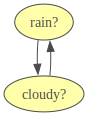

In [12]:
# 1. Create a Learner.
learner = ct.Learner('out/trajectory.csv')

# 2. Run learning algorithm
learned_ctbn = learner.learnCTBN()

# 3. Plot the learned CTBN
gnb.show(learned_ctbn)

Let's note that having a test object is necessary since we want to be able to test independency between variables.
For now only 2 tests are available : (Fisher and Chi2) test and Oracle test. Oracle test is only used for benchmarking since it uses the initial ctbn as a reference.

### Fitting parameters
It is also possible to approximate the transition time distributions of each variable, i.e the CIMs.

Note that conditioning variables are taken from the ctbn.

In [13]:
cims_before = ctbnnb.getCIMs(ctbn)
learner.fitParameters(ctbn)
cims_after = ctbnnb.getCIMs(ctbn)

gnb.sideBySide(cims_before, cims_after, captions=["original CIMs", "learned CIMs"])

## Example from [Nodelman et al, 2003]

This example comes from :
```
U. Nodelman, C.R. Shelton, and D. Koller (2003). "Learning Continuous Time Bayesian Networks." Proc. Nineteenth Conference on Uncertainty in Artificial Intelligence (UAI) (pp. 451-458). 
```


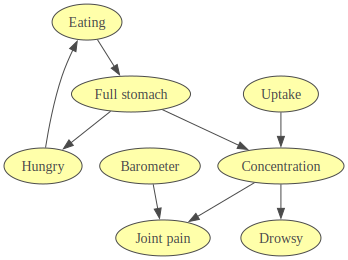

In [14]:
# 1. Creating the ctbn
drugEffect = ct.CTBN()

drugEffect.add(gum.LabelizedVariable("Eating", ""))
drugEffect.add(gum.LabelizedVariable("Hungry", ""))
drugEffect.add(gum.LabelizedVariable("Full stomach", ""))
drugEffect.add(gum.LabelizedVariable("Uptake", ""))
drugEffect.add(gum.LabelizedVariable("Concentration", "?"))
drugEffect.add(gum.LabelizedVariable("Barometer", ""))
drugEffect.add(gum.LabelizedVariable("Joint pain", ""))
drugEffect.add(gum.LabelizedVariable("Drowsy", ""))

drugEffect.addArc("Hungry","Eating")
drugEffect.addArc("Eating","Full stomach")
drugEffect.addArc("Full stomach","Hungry")
drugEffect.addArc("Full stomach","Concentration")
drugEffect.addArc("Uptake","Concentration")
drugEffect.addArc("Concentration","Drowsy")
drugEffect.addArc("Barometer","Joint pain")
drugEffect.addArc("Concentration","Joint pain")

gnb.show(drugEffect)

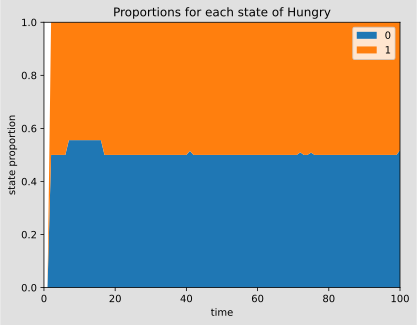

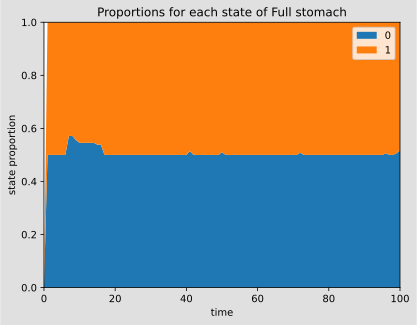

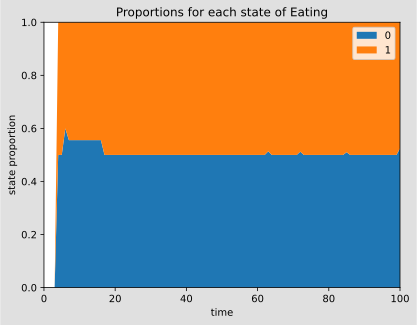

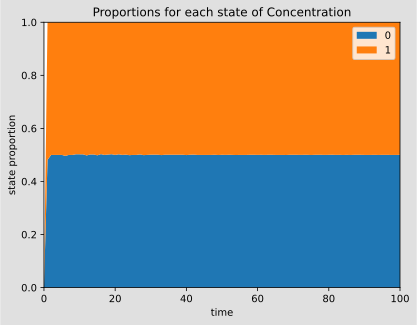

In [15]:
from pyagrum.ctbn.CTBNGenerator import randomCIMs

randomCIMs(drugEffect,(0.1,10))
drugEffect.CIM("Eating")[{"Hungry":0}]=[[-0.1,0.1],
                                        [10,-10]]
drugEffect.CIM("Eating")[{"Hungry":1}]=[[-2,2],
                                        [0.1,-0.1]]
drugEffect.CIM("Full stomach")[{"Eating":0}]=[[-0.1,0.1],
                                        [10,-10]]
drugEffect.CIM("Full stomach")[{"Eating":1}]=[[-2,2],
                                        [0.1,-0.1]]
drugEffect.CIM("Hungry")[{"Full stomach":0}]=[[-0.1,0.1],
                                        [10,-10]]
drugEffect.CIM("Hungry")[{"Full stomach":1}]=[[-2,2],
                                        [0.1,-0.1]]

ieX = ct.ForwardSamplingInference(drugEffect)
ieX.writeTrajectoryCSV("out/drugEffect.csv", n=3, timeHorizon=100)
trajX = ct.readTrajectoryCSV("out/drugEffect.csv") 

ct.plotFollowVar(drugEffect.variable("Hungry"), trajX)
ct.plotFollowVar(drugEffect.variable("Full stomach"), trajX)
ct.plotFollowVar(drugEffect.variable("Eating"), trajX)
ct.plotFollowVar(drugEffect.variable("Concentration"), trajX)

## Input/output with pickle for CTBN

In [16]:
import pickle
with open("test.pkl","bw") as f:
  pickle.dump(drugEffect,f)
drugEffect

In [17]:
with open("test.pkl","br") as f:
  copyDrug=pickle.load(f)
copyDrug